In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import matplotlib.pyplot as plt
import sys
import os
# import warnings
# warnings.filterwarnings('ignore')

#user = 'madams01'
#sys.path.append(f'/home/{user}/git_clones/copymltox/ml-tox/src')
sys.path.append("/home/ishah/ipynb/ml-tox/src")
from sklearn.linear_model import LogisticRegression
from mltox.db.mongo import *
from mltox.db.bc import *
from mltox.db.bio import *
from mltox.db.graph_utils import *

import functools
import deepchem as dc
import tensorflow as tf
import random

Skipped loading some Jax models, missing a dependency. No module named 'haiku'


In [11]:
DB5 = openMongo(db='genra_dev_v5',host='localhost',auth=False)

In [12]:
DB5

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'genra_dev_v5')

In [4]:
os.getcwd()

'/home/ishah/ipynb/ml-tox/notebooks/ma'

In [5]:
Assay_list = get_bio_assays(DB5.toxcast_assays)
prefixes = set([i.split('_')[0] for i in Assay_list])

prefix_list = []
for pre in prefixes:
        subset_assays = [i for i in Assay_list if i.startswith(pre)]
        if len(subset_assays) > 50:
            prefix_list.append((pre,len(subset_assays)))


In [6]:
prefix_list

[('ATG', 133), ('LTEA', 102), ('BSK', 87), ('NVS', 286), ('TOX21', 276)]

In [7]:
subset_assays = [i for i in Assay_list if i.startswith('ATG')]

len(subset_assays)
subset_assays

['ATG_AP_1_CIS',
 'ATG_AP_2_CIS',
 'ATG_AR_TRANS',
 'ATG_Ahr_CIS',
 'ATG_BRE_CIS',
 'ATG_CAR_TRANS',
 'ATG_CMV_CIS',
 'ATG_COUP_TF1_TRANS2',
 'ATG_COUP_TF2_TRANS2',
 'ATG_CRE_CIS',
 'ATG_C_EBP_CIS',
 'ATG_DAX1_TRANS2',
 'ATG_DR4_LXR_CIS',
 'ATG_DR5_RAR_CIS',
 'ATG_E2F_CIS',
 'ATG_EAR2_TRANS2',
 'ATG_EGR_CIS',
 'ATG_ERE_CIS',
 'ATG_ERRa_TRANS',
 'ATG_ERRb_TRANS2',
 'ATG_ERRg_TRANS',
 'ATG_ERa_TRANS',
 'ATG_ERb_TRANS2',
 'ATG_E_Box_CIS',
 'ATG_Ets_CIS',
 'ATG_FXR_TRANS',
 'ATG_FoxA2_CIS',
 'ATG_FoxO_CIS',
 'ATG_GAL4_TRANS',
 'ATG_GATA_CIS',
 'ATG_GCNF_TRANS2',
 'ATG_GLI_CIS',
 'ATG_GPCR_ADORA2A_TRANS',
 'ATG_GPCR_ADORA2B_TRANS',
 'ATG_GPCR_ADRA1A_TRANS',
 'ATG_GPCR_ADRA2B_TRANS',
 'ATG_GPCR_ADRB2_TRANS',
 'ATG_GPCR_ADRB3_TRANS',
 'ATG_GPCR_CHRM3_TRANS',
 'ATG_GPCR_DRD1_TRANS',
 'ATG_GPCR_DRD5_TRANS',
 'ATG_GPCR_EDNRA_TRANS',
 'ATG_GPCR_GCGR_TRANS',
 'ATG_GPCR_GPBAR1_TRANS',
 'ATG_GPCR_GPR40_TRANS',
 'ATG_GPCR_GQ_TRANS',
 'ATG_GPCR_GS1_TRANS',
 'ATG_GPCR_GS_TRANS',
 'ATG_GPCR_HRH1_TRANS',

In [9]:
DB5.toxcast_fp.create_index('dsstox_sid')
DB5.toxcast_fp.create_index('fits.assay_component_name')

'fits.assay_component_name_1'

In [ ]:
from mltox.db.graph_utils import *
Y0 = get_bio_data(DB5,subset_assays)

In [41]:
X0 = get_chm_data(DB5,Y0.dsstox_sid.tolist())

# if os.path.exists('ATG/X_smiles.pkl') and os.path.exists('ATG/Y_smiles.pkl'):
#         X = pd.read_pickle('ATG/X_smiles.pkl')
#         Y = pd.read_pickle('ATG/Y_smiles.pkl')
# else:
#     X.to_pickle('X_smiles.pkl')
#     Y.to_pickle('Y_smiles.pkl')

In [43]:
X0.head()

,dsstox_sid,mrgn_0,mrgn_1,mrgn_10,mrgn_100,mrgn_1000,mrgn_1001,mrgn_1002,mrgn_1003,mrgn_1004,...,mrgn_991,mrgn_992,mrgn_993,mrgn_994,mrgn_995,mrgn_996,mrgn_997,mrgn_998,mrgn_999,smiles
0,DTXSID0020232,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,CN1C=NC2=C1C(=O)N(C)C(=O)N2C
1,DTXSID0020236,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[Ca++].CC(O)C([O-])=O.CC(O)C([O-])=O
2,DTXSID0020280,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[O-][N+](=O)C1=C(Cl)C=CC=C1
3,DTXSID0020282,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NC1=CC(N)=C(Cl)C=C1
4,DTXSID0020284,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,OS(O)(=O)=O.NC1=CC=C(N)C(Cl)=C1


In [44]:
Y_new = replace_missing_data(Y0,"fill")


ValueError: invalid literal for int() with base 10: 'DTXSID0020232'

In [21]:
Y_new

,TOX21_AR_BLA_Agonist_ch1,TOX21_AR_BLA_Agonist_ch2,TOX21_AR_BLA_Agonist_ratio,TOX21_AR_BLA_Antagonist_ch1,TOX21_AR_BLA_Antagonist_ch2,TOX21_AR_BLA_Antagonist_ratio,TOX21_AR_BLA_Antagonist_viability,TOX21_AR_LUC_MDAKB2_Agonist,TOX21_AR_LUC_MDAKB2_Antagonist_10nM_R1881,TOX21_AR_LUC_MDAKB2_Antagonist_10nM_R1881_viability,...,TOX21_p53_BLA_p3_ratio,TOX21_p53_BLA_p3_viability,TOX21_p53_BLA_p4_ch1,TOX21_p53_BLA_p4_ch2,TOX21_p53_BLA_p4_ratio,TOX21_p53_BLA_p4_viability,TOX21_p53_BLA_p5_ch1,TOX21_p53_BLA_p5_ch2,TOX21_p53_BLA_p5_ratio,TOX21_p53_BLA_p5_viability
0,0,0,0,1,0,1,1,0,1,1,...,1,1,1,1,0,0,1,1,1,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8840,0,0,0,1,0,1,0,0,0,0,...,1,1,1,0,1,1,1,0,1,1
8841,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8842,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8843,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [22]:
smiles = X.values.tolist()

my_smiles = sum(smiles,[])

x = my_smiles
y = Y_new
dataset = dc.data.NumpyDataset(x, y)
trans = dc.trans.FeaturizationTransformer(dataset, dc.feat.ConvMolFeaturizer())
dataset = trans.transform(dataset)

[09:34:08] WARNING: not removing hydrogen atom without neighbors
[09:34:13] WARNING: not removing hydrogen atom without neighbors
[09:34:13] WARNING: not removing hydrogen atom without neighbors


In [20]:
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)
splitter = dc.splits.RandomStratifiedSplitter()

i = 0
train_dataset, _ ,test_dataset = splitter.train_valid_test_split(dataset,frac_train=0.8,frac_test=0.2,frac_valid=0.0,seed=i,               
                                                            test_dir=f'{os.getcwd()}/tmp_test_data/',
                                                            train_dir=f'{os.getcwd()}/tmp_train_data/',
                                                            valid_dir=f'{os.getcwd()}/tmp_valid_data/')
n_tasks = train_dataset.y.shape[1]
model = dc.models.GraphConvModel(n_tasks, mode='classification',model_dir=f'{os.getcwd()}/tmp_gcn_model/',tensorboard=True)



2022-11-15 16:35:51.964048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-15 16:35:51.965278: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-15 16:35:51.965331: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (v2626umcth033.rtord.epa.gov): /proc/driver/nvidia/version does not exist


In [ ]:
import glob, os

tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)
splitter = dc.splits.RandomStratifiedSplitter()

dfs = []
for i in range(20):
    train_dataset, _ ,test_dataset = splitter.train_valid_test_split(dataset,frac_train=0.8,frac_test=0.2,frac_valid=0.0,seed=i,               
                                                                test_dir=f'{os.getcwd()}/tmp_test_data/',
                                                                train_dir=f'{os.getcwd()}/tmp_train_data/',
                                                                valid_dir=f'{os.getcwd()}/tmp_valid_data/')
    n_tasks = train_dataset.y.shape[1]
    model = dc.models.GraphConvModel(n_tasks, mode='classification',model_dir=f'{os.getcwd()}/tmp_gc_model/')
    model.fit(train_dataset,nb_epoch=50)

    for f in glob.glob("/tmp/__autograph_generated_file*"):
        os.remove(f)

    Assay_list = Y_new.columns.tolist()
    y_true = test_dataset.y
    y_pred = model.predict(test_dataset)
    metric = dc.metrics.roc_auc_score
    scores = []
    for i in range(n_tasks):
        score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
        scores.append([Assay_list[i],score])

    df = pd.DataFrame(scores)
    dfs.append(df)


In [22]:
df_20 = pd.concat(dfs)
df_20.to_pickle('../tox21/gcn_20_50epoch_ltea.pkl')

df_20.mean()

/tmp/ipykernel_1926290/1438758229.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_20.mean()


1    0.707232
dtype: float64

Other Models -- WEAVE


In [23]:
featurizer = dc.feat.WeaveFeaturizer()
x = featurizer(my_smiles)
y = Y_new
dataset = dc.data.NumpyDataset(x, y)

[09:35:13] WARNING: not removing hydrogen atom without neighbors
[09:35:37] WARNING: not removing hydrogen atom without neighbors
[09:35:37] WARNING: not removing hydrogen atom without neighbors


In [ ]:
import glob, os

tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)
splitter = dc.splits.RandomStratifiedSplitter()

dfs = []
for i in range(10):
    train_dataset, _ ,test_dataset = splitter.train_valid_test_split(dataset,frac_train=0.8,frac_test=0.2,frac_valid=0.0,seed=i,               
                                                                test_dir=f'{os.getcwd()}/tmp_test_data/',
                                                                train_dir=f'{os.getcwd()}/tmp_train_data/',
                                                                valid_dir=f'{os.getcwd()}/tmp_valid_data/')
    n_tasks = train_dataset.y.shape[1]
    model = dc.models.WeaveModel(n_tasks=n_tasks, n_weave=2,mode="classification",model_dir=f'{os.getcwd()}/tmp_weave_model/',tensorboard=True)
    model.fit(train_dataset,nb_epoch=5)

    for f in glob.glob("/tmp/__autograph_generated_file*"):
        os.remove(f)

    Assay_list = Y_new.columns.tolist()
    y_true = test_dataset.y
    y_pred = model.predict(test_dataset)
    metric = dc.metrics.roc_auc_score
    scores = []
    for i in range(n_tasks):
        score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
        scores.append([Assay_list[i],score])

    df = pd.DataFrame(scores)
    dfs.append(df)


In [40]:
df_20 = pd.concat(dfs)

df_20.mean()

/tmp/ipykernel_2205375/2598201103.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_20.mean()


1    0.679904
dtype: float64

In [41]:

df_20 = pd.concat(dfs)
df_20.to_pickle('../tox21/weave_20_50.pkl')

df_20.mean()

/tmp/ipykernel_2205375/1293243723.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_20.mean()


1    0.679904
dtype: float64

In [38]:
df = pd.read_pickle('gcn_20_50epoch.pkl').groupby(0).mean()

df.std()

1    0.057397
dtype: float64

In [ ]:
model = dc.models.WeaveModel(n_tasks=n_tasks, n_weave=2, fully_connected_layer_sizes=[2000, 1000],mode="classification",modeldir=f'{os.getcwd()}/tmp_gc_model/')


In [11]:
import seaborn as sns
import pandas as pd

df = pd.read_pickle('../BSK/weave_20_10.pkl')

df.groupby(0).mean().mean()

1    0.706963
dtype: float64

(0.5, 0.8)

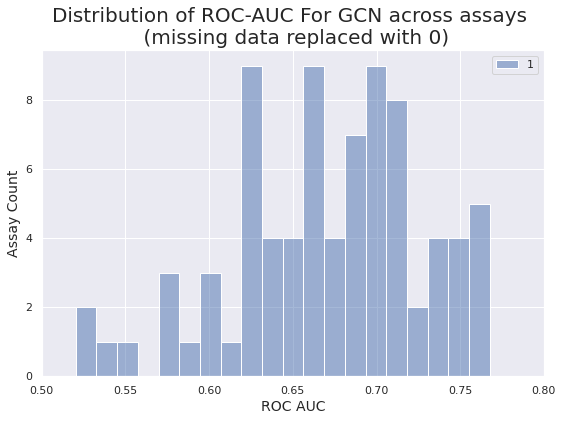

In [37]:


sns.set(rc={"figure.figsize":(9, 6)}) 
g = sns.histplot(df,bins=20)
g.set_xlabel('ROC AUC',fontsize=14)
g.set_ylabel('Assay Count',fontsize=14)
g.set_title('Distribution of ROC-AUC For GCN across assays \n (missing data replaced with 0)',fontsize=20)
g.set_xlim(0.5,0.8)

In [101]:
Assay_list = Y_new.columns.tolist()
y_true = test_dataset.y
y_pred = model.predict(test_dataset)
metric = dc.metrics.roc_auc_score
scores = []
for i in range(n_tasks):
    score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
    scores.append([Assay_list[i],score])

# 